# Modeling and measuring connection probability


If you pick two cortical cells at random, the probability that cell A connects to cell B depends on the spatial 
relationship between the cells. To a first approximation, connection probability decreases with the distance
between the cells because there is less opportunity for A's axon to overlap with B. Connectivity also depends on
the shape of each cell's processes and on other physiological factors that might prevent (or encourage) a
connection independently of spatial overlap. 

In the synphys dataset, we typically probe on the order of 100 possible connections for each cell type combination
(for example, L4 pyramidal cells synapsing onto L4 Pvalb cells). This low N constrains the range of
hypotheses we are able to test, so to keep things simple we consider connection probability to be a strict
function of euclidean intersomatic distance.

In this notebook we explore the ways that we can model this relationship, and how best to make use of this information in the synphys dataset. In prior literature, it is common to simply count all connections found within a certain distance (usually around 100 µm), divide by the number of connections tested in that same window, and simply report connectivity as a proportion. One shortcoming of this approach is that it becomes difficult to compare these metrics if you are not certain that the distances _tested_ are similarly distributed. Prior studies often make some effort to ensure that is true within the data being published. However, in most cases this makes it difficult or impossible to compare such values _between_ studies. A major motivation for the analysis that follows here is to select a metric that could be used by future studies as a standard measure of connectivity that is relatively insensitive to the exact distances tested.

Additionally, measures of connectivity can be highly unreliable in cases with low N or where connection probability is low. A second motivation for the analysis in this notebook is to determine how best to measure and mitigate that unreliability.


Questions we want to address here: given a list of the distances at which connections are probed and found,
1. What is the best way to model a connection probability profile?
2. What is the best way to fit a connection probability profile?
3. What is the best way to determine confidence intervals on that fit?


# Question 1: What is the best way to _model_ a connection probability profile?

A principled approach here might try to model the overlap between the presynaptic axonal arbor and the postsynaptic  soma and dendritic arbor. That approach is a bit out of scope here, but in the simplest approach one might consider connection probability to be related to the volume overlap of two intersecting spheres. Assuming a certain average density of synaptic connections from one cell type onto another, we can estimate the number of expected synapses between two cells based on their size and intersomatic distance. From there, we can treat connectivity as a poisson process to estimate the probability of two cells being connected as a function of intersomatic distance.

The intent of this exercise is just to get a sense of the shapes we might expect to see when measuring connectivity profiles:

In [1]:
import warnings
import numpy as np
import scipy.optimize


class Model:
    def generate(self, x, seed=None):
        """Generate a random sample of connectivity, given distances at which connections are tested.
        
        The *seed* parameter allows a random seed to be provided so that results are frozen across executions.
        """
        p = self.connection_probability(x)
        rng = np.random.RandomState(seed)
        return rng.random(size=len(x)) < p

    def likelihood(self, x, conn):
        """Log-likelihood for maximum likelihood estimation

        LLF = Σᵢ(𝑦ᵢ log(𝑝(𝐱ᵢ)) + (1 − 𝑦ᵢ) log(1 − 𝑝(𝐱ᵢ)))
        """
        assert np.issubdtype(conn.dtype, np.dtype(bool))
        p = self.connection_probability(x)
        return np.log(p[conn]).sum() + np.log((1-p)[~conn]).sum()

    def connection_probability(self, x):
        """Return the probability of seeing a connection from cell A to cell B given 
        the intersomatic distance *x*.
        
        This does _not_ include the probability of the reverse connection B→A.
        """
        raise NotImplementedError('connection_probability must be implemented in a subclass')
    
    @classmethod
    def err_fn(cls, params, *args):
        model = cls(*params)
        return -model.likelihood(*args)

    @classmethod
    def fit(cls, x, conn, init=(0.1, 150e-6), bounds=((0.001, 1), (10e-6, 1e-3)), **kwds):
        n = 6
        p_bins = np.linspace(bounds[0][0], bounds[0][1], n)
        s_bins = np.linspace(bounds[1][0], bounds[1][1], n)
        best = None
        # Most minimization methods fail to find the global minimum for this problem.
        # Instead, we systematically search over a large (n x n) range of the parameter space
        # and pick the best overall fit.
        for p_bin in zip(p_bins[:-1], p_bins[1:]):
            for s_bin in zip(s_bins[:-1], s_bins[1:]):
                init = (np.mean(p_bin), np.mean(s_bin))
                bounds = (p_bin, s_bin)

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")    
                    fit = scipy.optimize.minimize(
                        cls.err_fn, 
                        x0=init, 
                        args=(x, conn),
                        bounds=bounds,
                        **kwds,
                    )
                    if best is None or fit.fun < best.fun:
                        best = fit
        
        ret = cls(*best.x)
        ret.fit_result = best
        return ret


class SphereIntersectionModel(Model):
    """Model connection probability as proportional to the volume overlap of intersecting spheres.

    Parameters
    ----------
    pmax : float
        Maximum connection probability (at 0 intersomatic distance)
    size : float
        Radius of a single cell
    density : float
        Average number of synapses per m^3 connecting one cell to another, within their overlapping volume.        

    Note: the *pmax* and *density* parameters are redundant; can be instantiated using either 
    (pmax, size) or (density, size).
    """
    def __init__(self, pmax=None, size=None, density=None):
        assert size is not None
        assert (pmax is not None) or (density is not None)
            
        self._pmax = pmax
        self.size = size
        self._density = density

    @property
    def r(self):
        """Radius of cell; overlapping region extends to 2*r.
        """
        return self.size
        
    @property
    def density(self):
        """Average density of synapses in overlapping regions (synapses / m^3)"""
        if self._density is None:
            # calculate synapse density needed to get pmax
            return np.log(1 - self.pmax) / (-(4/3) * np.pi * self.r**3)
        else:
            return self._density

    @density.setter
    def density(self, d):
        self._density = d
        self._pmax = None

    @property
    def pmax(self):
        """Maximum connection probability at intersomatic distance=0
        """
        if self._pmax is None:
            return self.connection_probability(0)
        else:
            return self._pmax

    @pmax.setter
    def pmax(self, p):
        self._pmax = p
        self._density = None
    
    def connection_probability(self, x):
        # In a Poisson process, the probability of seeing 0 events in an interval is exp(-λ), where
        # λ is the average number of events in an interval. If we let *density* in this case be the average
        # number of synapses per unit volume, then λ = density * V, and the probability of seeing no events
        # in V is just P(V,density) = exp(-denstiy*V).
        
        r = self.r
        density = self.density
        
        # volume of overlap between spheres at distance x
        v = self.volume_overlap(x)
        
        # probability of 1 or more synapse given v and density
        p = 1 - np.exp(-v * density)
        
        # clip probability at 0.005 to allow for a small number of
        # connections past 2*r (otherwise fitting becomes impossible)
        return np.clip(p, 0.005, 1)
    
    def volume_overlap(self, x):
        r = self.r
        v = (4 * np.pi / 3) * r**3 - np.pi * x * (r**2 - x**2/12)
        return np.where(x < r*2, v, 0)


class ExpModel(Model):
    """Model connection probability as an exponential decay
    
    Parameters
    ----------
    pmax : float
        Maximum connection probability (at 0 intersomatic distance)
    size : float
        Exponential decay tau
    
    """
    def __init__(self, pmax, size):
        self.pmax = pmax
        self.size = size
    
    def connection_probability(self, x):
        return self.pmax * np.exp(-x / self.size)

    
class LinearModel(Model):
    """Model connection probability as linear decay to 0

    Parameters
    ----------
    pmax : float
        Maximum connection probability (at 0 intersomatic distance)
    size : float
        Distance at which connection probability reaches its minimum value
        
    Note: in this model, connection probability goes only to 0.5% at minimum.
    If the minimum is allowed to go to 0, then fitting becomes more difficult.
    """
    def __init__(self, pmax, size):
        self.pmax = pmax
        self.size = size

    def connection_probability(self, x):
        return np.clip(self.pmax * (self.size - x) / self.size, 0.005, 1)


class GaussianModel(Model):
    """Model connection probability as gaussian centered at x=0

    Parameters
    ----------
    pmax : float
        Maximum connection probability (at 0 intersomatic distance)
    size : float
        Gaussian sigma
    """
    def __init__(self, pmax, size):
        self.pmax = pmax
        self.size = size

    def connection_probability(self, x):
        return self.pmax * np.exp(-x**2 / (2 * self.size**2))

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

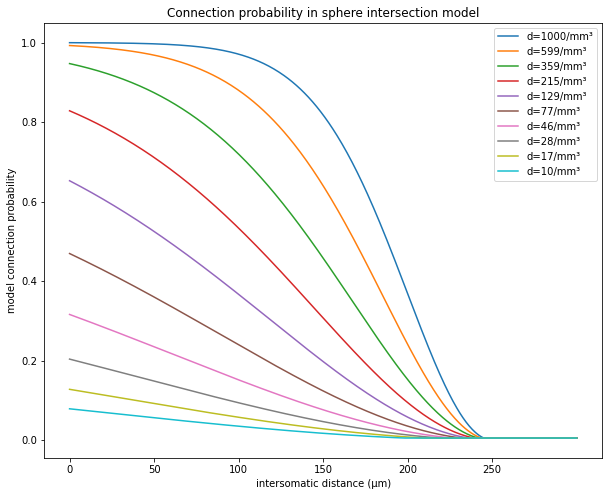

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))
ticks = np.arange(0, 300e-6, 50e-6)
ax.set_xticks(ticks)
ax.set_xticklabels(['%0.0f'%(x*1e6) for x in ticks])
ax.set_xlabel('intersomatic distance (μm)')
ax.set_ylabel('model connection probability')
ax.set_title('Connection probability in sphere intersection model')

x = np.linspace(0, 300e-6, 500)
# maximum synapse density of 1 per 100x100x100µm cube
max_density = 1 / 100e-6**3
densities = max_density * 10**np.linspace(0, -2, 10)
for density in densities:
    model = SphereIntersectionModel(density=density, size=125e-6)
    y = model.connection_probability(x)
    plt.plot(x, y, label="d=%0.0f/mm³"%(density/1e9))
    
ax.legend();


In prior studies, it is common to model connection profiles as gaussian or exponential decay. From the results above, it looks like either approach should be a reasonably good model depending on the expected overall level of connectivity.

Below, we will load some connectivity data from the synphys database and test the 4 models defined above: ShereIntersection, Gaussian, Exponential, and Linear.

In [4]:
from aisynphys.database import default_db as db

In [5]:
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import pair_was_probed

In [6]:
from aisynphys.connectivity import connectivity_profile

def show_experiment_result(x_probed, conn, fit, ax, true_model=None, ymax=None):
    # where to bin connections for measuring connection probability
    x_bins = np.arange(0, 500e-6, 40e-6)

    # where to sample models
    #x_vals = 0.5 * (x_bins[1:] + x_bins[:-1])
    x_vals = np.linspace(x_bins[0], x_bins[-1], 200)

    # plot the ground-truth probability distribution (solid green)
    if true_model is not None:
        ax.plot(x_vals, true_model.connection_probability(x_vals), color=(0, 0.5, 0))

    # plot the connectivity profile with confidence intervals (black line / grey area)
    _, cprop, lower, upper = connectivity_profile(conn, x_probed, x_bins)
    ax.plot(x_bins, np.append(cprop, cprop[-1]), drawstyle='steps-post', color=(.5, .5, .5))
    ax.fill_between(x_bins, np.append(lower, lower[-1]), np.append(upper, upper[-1]), step='post', color=(0.85, 0.85, 0.85))

    if ymax is None:
        ymax = upper.max()
    
    # plot the fit result (thick red)
    ax.plot(x_vals, fit.connection_probability(x_vals), color=(0.5, 0, 0))

    # plot connections probed and found
    # warning: some mpl versions have a bug that causes the data argument to eventplot to be modified
    alpha1 = np.clip(30 / len(x_probed), 1/255, 1)
    alpha2 = np.clip(30 / conn.sum(), 1/255, 1)
    tickheight = ymax / 10
    ax.eventplot(x_probed.copy(), lineoffsets=-tickheight*2, linelengths=tickheight, color=(0, 0, 0, alpha1))
    ax.eventplot(x_probed[conn], lineoffsets=-tickheight, linelengths=tickheight, color=(0, 0, 0, alpha2))

    err = 0 if not hasattr(fit, 'fit_result') else fit.fit_result.fun
    label = "Fit pmax=%0.2f\nsize=%0.2f µm\nerr=%f" % (fit.pmax, fit.size*1e6, err)
    ax.text(0.99, 0.85, label, transform=ax.transAxes, color=(0.5, 0, 0), horizontalalignment='right')
    
    if true_model is not None:
        label = "True pmax=%0.2f\nsize=%0.2f µm" % (true_model.pmax, true_model.size*1e6)
        ax.text(0.99, 0.95, label, transform=ax.transAxes, color=(0, 0.5, 0), horizontalalignment='right')
    
    ax.axhline(0)
    
    ax.set_xlabel('distance (µm)')
    xticks = np.arange(0, x_vals.max(), 50e-6)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%0.0f'%(x*1e6) for x in xticks])

    y_vals = np.arange(0, ymax + 0.1, 0.1)
    ax.set_yticks([-tickheight*2, -tickheight] + list(y_vals))
    ax.set_yticklabels(['probed', 'connected'] + ['%0.1f'%x for x in y_vals])
    ax.set_ylim(-tickheight*2.6, ymax)
    

Load connections from the database. Group by excitatory, inhibitory, and both combined:

In [7]:
# select all excitatory / inhibitory pairs
filters = {'project_name': ["mouse V1 coarse matrix", "mouse V1 pre-production"]}
ex_pairs = db.pair_query(pre_class=CellClass(cell_class_nonsynaptic='ex'), **filters).all()
in_pairs = db.pair_query(pre_class=CellClass(cell_class_nonsynaptic='in'), **filters).all()

# filter for only those with connectivity probed and distance known
ex_pairs = [p for p in ex_pairs if pair_was_probed(p, 'ex') and p.distance is not None and p.distance < 500e-6 and p.has_synapse is not None]
in_pairs = [p for p in in_pairs if pair_was_probed(p, 'in') and p.distance is not None and p.distance < 500e-6 and p.has_synapse is not None]

# get intersomatic distances
ex_dist = np.array([p.distance for p in ex_pairs])
in_dist = np.array([p.distance for p in in_pairs])
all_dist = np.concatenate([in_dist, ex_dist])

# get connectivity
ex_conn = np.array([p.has_synapse for p in ex_pairs], dtype=bool)
in_conn = np.array([p.has_synapse for p in in_pairs], dtype=bool)
all_conn = np.concatenate([in_conn, ex_conn])

Fit each of the 4 models to each of the 3 synapse groups so we can compare:

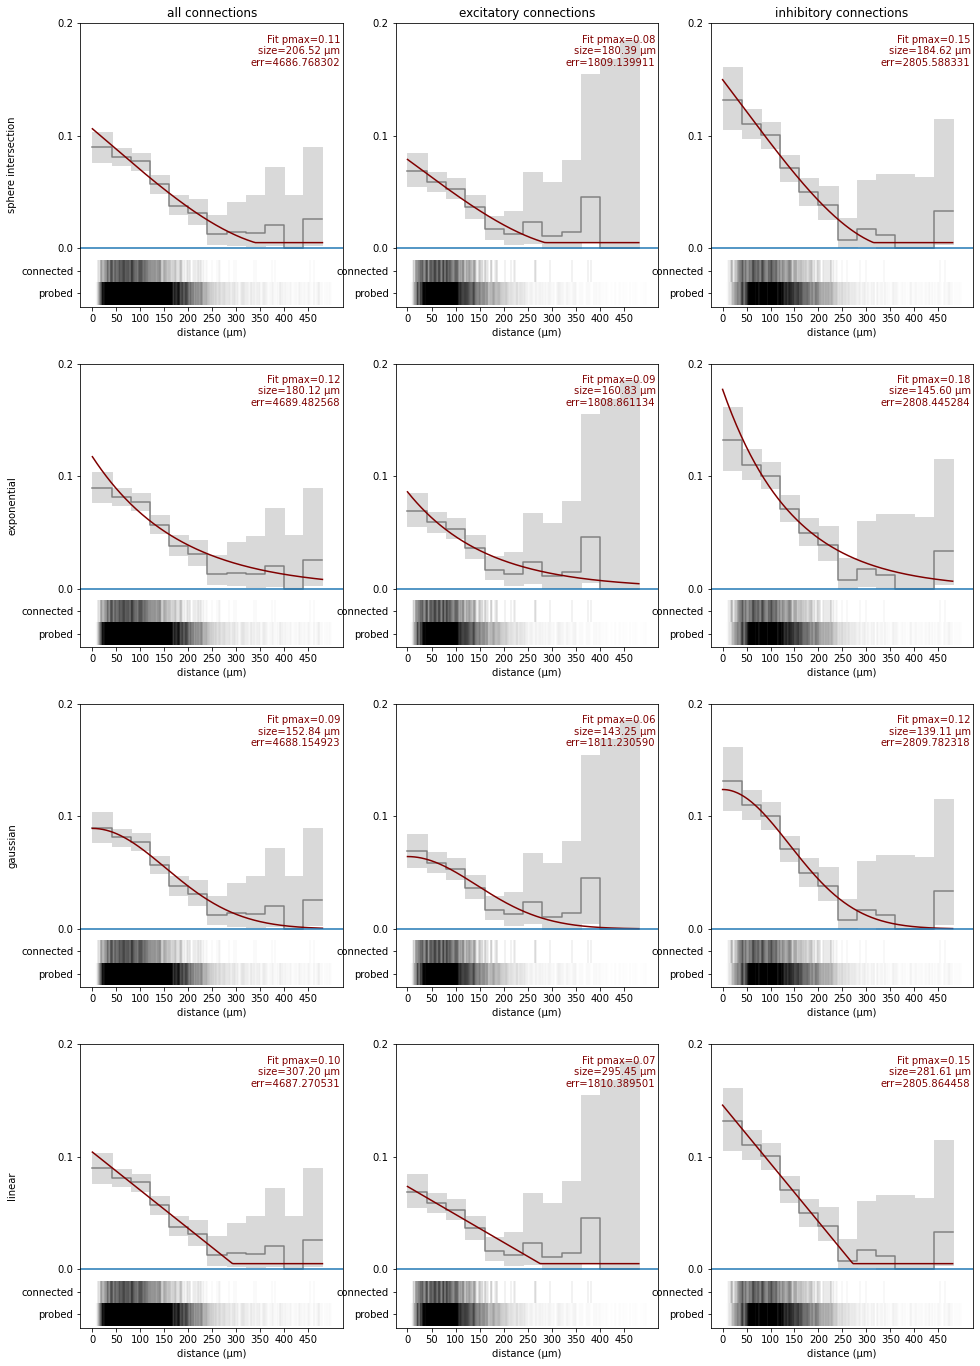

In [8]:
model_classes = {
    'sphere intersection': SphereIntersectionModel,
    'exponential': ExpModel,
    'gaussian': GaussianModel,
    'linear': LinearModel,
}


fig, ax = plt.subplots(len(model_classes), 3, figsize=(16, 6*len(model_classes)))

for i, (model_name, model_class) in enumerate(model_classes.items()):
    # fit
    method = 'L-BFGS-B'
    ex_fit = model_class.fit(ex_dist, ex_conn, method=method)
    in_fit = model_class.fit(in_dist, in_conn, method=method)
    all_fit = model_class.fit(all_dist, all_conn, method=method)

    show_experiment_result(all_dist, all_conn, all_fit, ax[i, 0], ymax=0.2)
    show_experiment_result(ex_dist, ex_conn, ex_fit, ax[i, 1], ymax=0.2)
    show_experiment_result(in_dist, in_conn, in_fit, ax[i, 2], ymax=0.2)
    
    ax[i, 0].set_ylabel(model_name)

ax[0, 0].set_title('all connections')
ax[0, 1].set_title('excitatory connections')
ax[0, 2].set_title('inhibitory connections');


In the plots above, all 4 models seem to do a reasonably good job of fitting the raw data, with only slight differences in fit error. Qualitativly, the Gaussian model seems a better fit so **for this notebook we are simply assuming the gaussian model**. You can explore the effects of different models by setting the
`true_model_class` and `test_model_class` variables in the cell below.

In [9]:
# The "true" connection probability distribution model used to generate simulated 
# experiment results for the remainder of this notebbok.
true_model_class = GaussianModel


# The connection probability model used for _fitting_ for the remainder of
# this notebook.
test_model_class = GaussianModel

## Quick test: simulate a single connectivity experiment
(probe many connections and make an estimate of the connection probability vs distance relationship)

The models above are fit against thousands of pooled connections. In many cases, though, we are interested in fitting only about 100 connections in order to look at differences in connectivity at the cell subclass level (for example, we might pool all connections from layer 5 pyramidal cells onto layer 5 SST cells). 

Below, we explore model performance on datasets of only 100 connections.

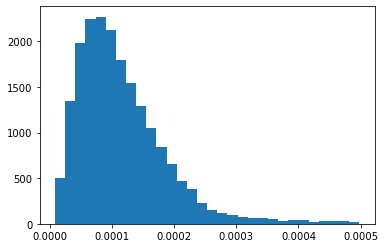

In [10]:
# Plot the distribution of distances sampled in our dataset.
# We will use this distribution later to simulate new experiments.
import scipy.stats

fig,ax = plt.subplots()
h = ax.hist(all_dist, bins=30)

Above is the distribution of intersomatic distances sampled in our data. We will randomly select 100 elements from this distribution to simulate.

In [11]:
# Pick parameters for a "true" connectivity distribution model
pmax = 0.3
size = 150e-6
true_model = true_model_class(pmax, size)

# How many connections probed per experiment
n_probes = 100

# Select random distance sampling from the real distribution
rng = np.random.RandomState(1234)
x_probed = rng.choice(all_dist, size=n_probes)

# run the 'experiment' (measure connectivity at the chosen distances)
conn = true_model.generate(x_probed, seed=1234)

# fit the measured connectivity data
fit = test_model_class.fit(x_probed, conn)

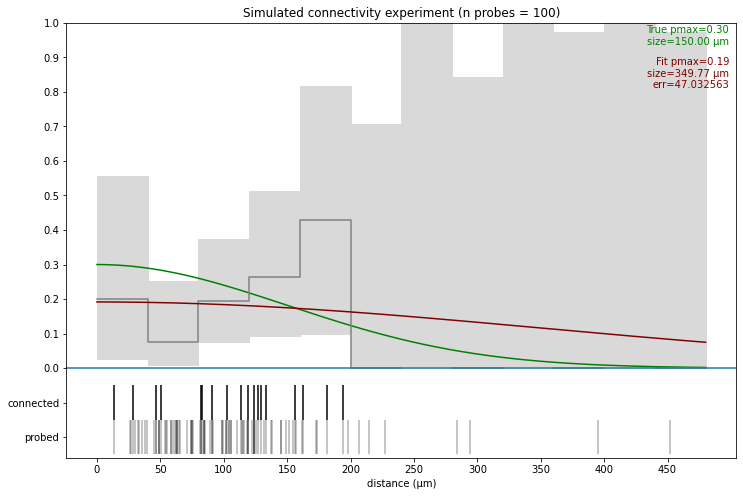

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Simulated connectivity experiment (n probes = %d)" % n_probes)
show_experiment_result(x_probed, conn, fit, ax, true_model=true_model)

**In the plot above:**
- Green line shows the actual connection probability model used to simulate the experiment
- Grey ticks (bottom row) are the intersomatic distances for pairs that were _tested_ for connectivity
- Grey ticks (top row) are the pairs that were _actually connected_ in the simulation
- Grey line / area shows binned connection proportions and 95% confidence intervals 
- Red line shows the fit to the simulated connectivity data

A few things become apparent when playing with this simulation:
- 95% confidence intervals on binned connection probability are quite wide
- Gaussian sigma is poorly constrained unless n_probes is very large (~10k)
- We need to think carefully about how best to fit the data



# Question 2: What is the best way to _fit_ a connection probability distribution?

The classes below extend GaussianModel to implement and compare a few different fitting algorithms:
- Maximum likelihood estimation against (distance, binary_connections)
- A few variants on least-squares curve fit against (bin_distance, binned_connection_proportion)
- Maximum likelihood estimation with fixed and bounded sigma values

In [13]:
import scipy.optimize

class ProfileFitModel(test_model_class):
    """Least-squares fit the model function to binned connectivity proportions.
    """
    weight_bins = False
    
    @classmethod
    def fit(cls, x, conn, init=(0.1, 100e-6), bounds=((0.001, 1), (10e-6, 1e-3)), **kwds):
        x_bins = np.arange(0, x.max(), 40e-6)
        _, cprop, lower, upper = connectivity_profile(conn, x, x_bins)

        bin_masks = [((x>x_bins[i]) & (x<= x_bins[i+1])) for i in range(len(x_bins)-1)]
        if cls.weight_bins:
            # count number of connections probed in each bin; weight the fit accordingly
            bin_weights = [m.sum() for m in bin_masks]
        else:
            bin_weights = np.ones(len(cprop))
            
        # x values are just the center of each bin
        x_vals = 0.5 * (x_bins[1:] + x_bins[:-1])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")    
            fit = scipy.optimize.minimize(
                cls.err_fn, 
                x0=init, 
                args=(x_vals, cprop, bin_weights),
                bounds=bounds,
                **kwds,
            )
        ret = cls(*fit.x)
        ret.fit_result = fit
        return ret

    @classmethod
    def err_fn(cls, params, *args):
        model = cls(*params)
        x, p, weights = args
        connection_probability = model.connection_probability(x)
        rms = ((weights * (connection_probability - p)) ** 2).sum() ** 0.5
        return rms

class WeightedProfileFitModel(ProfileFitModel):
    """Least-squares fit against binned connection proportions, with weighting
    based on number of elements in each bin
    """
    weight_bins = True
    
class EvenBinModel(ProfileFitModel):
    """Least-squares fit against binned connection proportions, with bins selected
    to contain equal numbers of connection tests
    """
    n_bins = 4
    
    @classmethod
    def fit(cls, x, conn, init=(0.1, 100e-6), bounds=((0.001, 1), (10e-6, 1e-3)), **kwds):
        order = np.argsort(x)
        x = x[order]
        conn = conn[order]
        bin_size = len(x) // cls.n_bins
        x_bins = [x[i*bin_size:(i+1)*bin_size] for i in range(cls.n_bins)]
        n_probe = [len(b) for b in x_bins]
        x_vals = np.array([np.mean(b) for b in x_bins])
        conn_bins = [conn[i*bin_size:(i+1)*bin_size] for i in range(cls.n_bins)]
        cprop = np.array([np.sum(conn_bins[i]) / n_probe[i] for i in range(cls.n_bins)])
        
        bin_weights = np.ones(len(cprop))
        
        fit = scipy.optimize.minimize(
            cls.err_fn, 
            x0=init, 
            args=(x_vals, cprop, bin_weights),
            bounds=bounds,
            **kwds,
        )
        ret = cls(*fit.x)
        ret.fit_result = fit
        return ret
    
# class FixedSizeModel(test_model_class):
#     """Maximum likelihood estimation with fixed size
#     """
#     @classmethod
#     def fit(cls, x, conn, init=(0.1, 150e-6), bounds=((0.001, 1), (149e-6, 151e-6)), **kwds):
#         return test_model_class.fit(x, conn, init, bounds, **kwds)
    
class BoundedSizeModel(test_model_class):
    """Maximum likelihood estimation with bounded size
    """
    @classmethod
    def fit(cls, x, conn, init=(0.1, 150e-6), bounds=((0.001, 1), (75e-6, 200e-6)), **kwds):
        return test_model_class.fit(x, conn, init, bounds, **kwds)


class FixedSizeModel(test_model_class):
    @classmethod
    def fit(cls, x, conn, init=0.1, bounds=(0.001, 1), **kwds):
        fixed_size = kwds.pop('size', 150e-6)
        
        if conn.sum() == 0:
            # fitting falls apart at 0; just return the obvious result
            return cls(0, fixed_size)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")    
            fit = scipy.optimize.minimize(
                cls.err_fn, 
                x0=(init,), 
                args=(fixed_size, x, conn),
                bounds=(bounds,),
                **kwds,
            )
        
        ret = cls(fit.x[0], fixed_size)
        ret.fit_result = fit
        return ret
    
    @classmethod
    def err_fn(cls, params, *args):
        (pmax,) = params
        size, x, conn = args
        model = cls(pmax, size)
        return -model.likelihood(x, conn)    

Run many simulated experiments, fit using several different approaches:

In [14]:
# how many experiments to run
n_trials = 1000

# how many cell pairs to test in each experiment
n_probes = 100

trials = []
test_models = {
    'max_likelihood': test_model_class,
    'binned_cp': ProfileFitModel,
    'binned_cp + weights': WeightedProfileFitModel,
    'equal_binned_cp': EvenBinModel,
    'mle_fixed_size': FixedSizeModel,
    'mle_bounded_size': BoundedSizeModel,
}

pmax_range = (0, 1)
size_range = (100e-6, 200e-6)

rng = np.random.RandomState(3456)
for i in range(n_trials):
    # run an experiment
    pmax = rng.uniform(*pmax_range)
    size = rng.uniform(*size_range)
    true_model = true_model_class(pmax, size)
    x_probed = rng.choice(all_dist, size=n_probes)
    connected = true_model.generate(x_probed, seed=3456)
    trials.append({'true': true_model})
    
    # try different fitting methods
    for model_name, model_class in test_models.items():
        fit = model_class.fit(x_probed, connected)
        trials[-1][model_name] = fit

Plot and compare results:

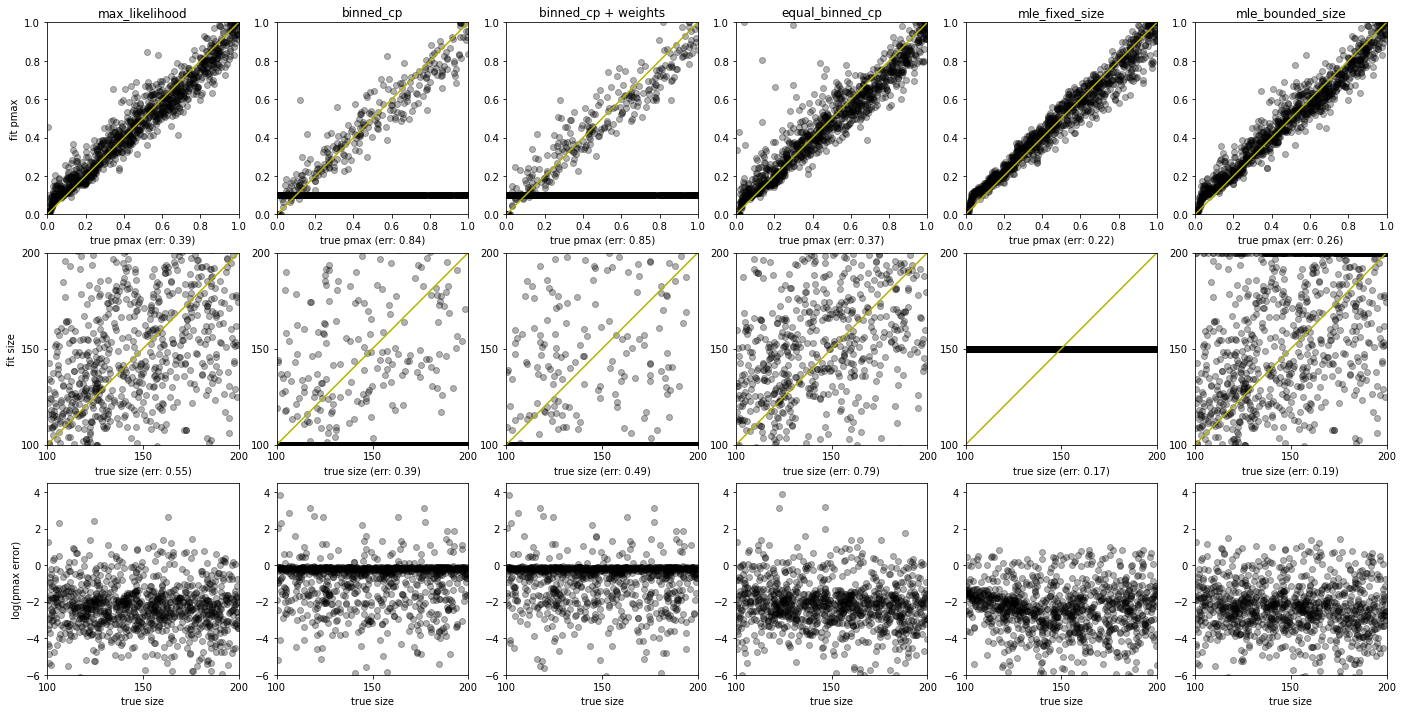

In [15]:
fig, ax = plt.subplots(3, len(test_models), figsize=(4*len(test_models), 12))

for i,model_name in enumerate(test_models.keys()):
    # plot fit pmax vs true pmax
    pmax_x = np.array([trial['true'].pmax for trial in trials])
    pmax_y = np.array([trial[model_name].pmax for trial in trials])
    ax[0, i].scatter(pmax_x, pmax_y, color=(0, 0, 0, 0.3))
    ax[0, i].plot([0, 1], [0, 1], color=(0.7, 0.7, 0))
    ax[0, i].set_xlim(*pmax_range)
    ax[0, i].set_ylim(*pmax_range)    
    ax[0, i].set_title(model_name)
    
    pmax_err = (np.abs(pmax_x - pmax_y) / pmax_x).mean()
    ax[0, i].set_xlabel("true pmax (err: %0.2f)" % (pmax_err))

    # plot fit size vs true size
    size_x = np.array([trial['true'].size for trial in trials])
    size_y = np.array([trial[model_name].size for trial in trials])
    ax[1, i].scatter(size_x, size_y, color=(0, 0, 0, 0.3))
    ax[1, i].plot([0, 1], [0, 1], color=(0.7, 0.7, 0))
    ax[1, i].set_xlim(*size_range)
    ax[1, i].set_ylim(*size_range)
    
    size_err = (np.abs(size_x - size_y) / size_x).mean()
    ax[1, i].set_xlabel("true size (err: %0.2f)" % (size_err))
    
    tick_vals = np.arange(size_range[0], size_range[1]+1e-6, 50e-6)
    ax[1, i].set_xticks(tick_vals)
    ax[1, i].set_xticklabels(["%0.0f"%(x*1e6) for x in tick_vals])
    ax[1, i].set_yticks(tick_vals)
    ax[1, i].set_yticklabels(["%0.0f"%(x*1e6) for x in tick_vals])

    # plot pmax error versus true size
    y = np.log(np.abs(pmax_x - pmax_y) / pmax_x)
    ax[2, i].scatter(size_x, y, color=(0, 0, 0, 0.3))
    ax[2, i].set_xlabel("true size")
    ax[2, i].set_xlim(*size_range)
    ax[2, i].set_xticks(tick_vals)
    ax[2, i].set_xticklabels(["%0.0f"%(x*1e6) for x in tick_vals])
    ax[2, i].set_ylim(-6, 4.5)
    
ax[0, 0].set_ylabel('fit pmax')
ax[1, 0].set_ylabel('fit size')
ax[2, 0].set_ylabel('log(pmax error)');


In the plot above:
- Each column contains results from a different fitting algorithm
- Top row shows the fit amplitude value (y) vs true amplitude value (x); a perfect fit would be on the x-y diagonal
- Middle row shows fit gaussian sigma (y) vs true sigma (x)
- Bottom row shows the fractional error in the fit amplitude vs true sigma value. This lets us decide how the true sigma value affects our ability to accurately fit the amplitude.

**Main conclusions are:**
- **Maximum likelihood estimation generally yields smaller errors (and bonus: it's simpler)**
- **Sigma is very poorly constrained; so much that we do not consider the fit sigma values to be useful**
- **Using a fixed or bounded sigma value provides the best estimate on amplitude, even in cases where the fixed sigma differs significantly from the true sigma**

Since we can't reliably measure the gaussian sigma parameter with n=100, going forward we will only fit with fixed sigma. This has a benefit of making the fitting process much less computationally expensive; we just need to decide on an appropriate fixed value. Earlier in this notebook, we fit gaussian curves to pooled connections, with σ values about 140-150 µm. For the remainder of this notebook, we are choosing 150 µm as the fixed σ for gaussian fits.

In [16]:
test_model_class = FixedSizeModel
fixed_size = 150e-6

A nice, smooth error surface. Impossible to miss the global minimum, and possibly has an analytical solution.

Depends strongly on the number of connections and the distances probed, but only weakly on the actual distances at which those connections are found; perhaps we can make a simplification?


# Question 3: How can we estimate confidence intervals on fit parameters?

The fitting procedure we settled on above describes connectivity as a single value--the amplitude of the gaussian fit. However, we intend to use this metric to describe and compare synapse types where we have only sparsely sampled the population. In cases of low n, this metric may be very different from the true population value. To complement the amplitude metric, then, we are looking for a way to describe the _range_ of likely population values (a confidence interval) that could have yielded the samples we ended up with. 

Intuitively, we expect the range to be narrower for synapse types that have been more densely sampled, since the connectivity metric should tend toward the population value as we collect more data. We also find that synapse types that are more heavily connected require fewer samples to achive narrow confidence intervals.

A natural first attempt would be to use resampling with replacement to calculate a bootstrap confidence interval. This does work for some cases, but fails when connectivity is low. As an example, let's say we sample a synapse type 100 times and find no connections. We know that our confidence interval should include 0 (it's possible this type is not connected at all) and extend up to some low value (it's possible this type _is_ sparsely connected; we simply got unlucky and failed to catch any synapses). In bootstraping, we simply resample the original data (pick 100 random items from the original set, where some items may be picked multiple times) but because there are no connections found in the original data, resampling will never yield a connectivity other than 0, and thus gives an impossibly narrow confidence interval. 




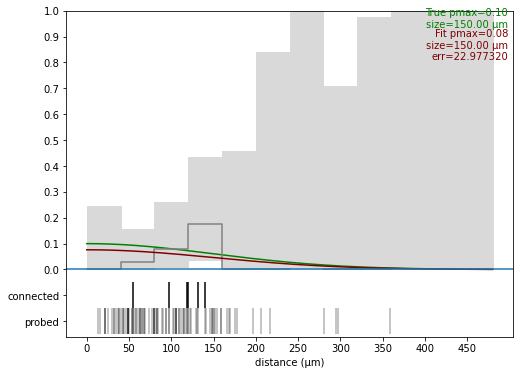

In [17]:
# Run one experiment, then we'll try different ways of generating confidence intervals on the fit amplitude

# How many connections probed per experiment
n_probes = 100

# Select random distance sampling from the real distribution
rng = np.random.RandomState(5567)
x_probed = rng.choice(all_dist, size=n_probes)

true_model = true_model_class(pmax=0.1, size=fixed_size)

conn = true_model.generate(x_probed, seed=5567)

fit = test_model_class.fit(x_probed, conn, size=fixed_size)
    
fig, ax = plt.subplots(figsize=(8,6))
show_experiment_result(x_probed, conn, fit, ax, true_model)

**Brute-force method:** run many simulated experiments to measure reliability of fitting procedure.

Note: one confound here is that we don't know the best way to distribute our tests among true pmax values. The approach we have taken here is to assume pmax values are uniformly distributed from 0 to 1, but it's likely we could do better by thinking about that more carefully.

In [18]:
def measure_confidence_region(x_probed, target_pmax, pmax_resolution=0.01, n_trials_per_pmax=100):
    """Run many simulated connectivity experiments to determine how frequently each pmax value generates a fit
    with a known target pmax value. This can be used to generate confidence intervals on the fit pmax parameter.
    
    Parameters
    ----------
    x_probed : array
        Distances at which connections are probed in all simulated experiments
    target_pmax : float
        The pmax value of interest; for optimization, this function stops testing
        in regions where target_pmax is very rarely seen.
    pmax_resolution : float
        Tests simluated pmax values in increments defined by this value
    n_trials_per_pmax : int
        Number of trials to run for each simulated pmax value

    Returns
    -------
    results : array
        2D array with one row per simulation run; 3 columns: (simulated_pmax, fit_pmax, n_connected)
    """
    # round to nearest pmax_reolution
    target_pmax = np.round(target_pmax / pmax_resolution) * pmax_resolution
    
    #fit_opts = {'method': 'L-BFGS-B', 'options': {'ftol': 0.1, 'gtol': 0.1}}
    #fit_opts = {'method': 'Nelder-Mead', 'options': {}}
    fit_opts = {'method': 'SLSQP', 'options': {'ftol': 0.001}}

    direction = 1

    # keep records of every simulation
    results = []

    current_pmax = target_pmax
    j = 0
    while current_pmax >= 0:
        fit_amps = []
        for i in range(n_trials_per_pmax):
            true_model1 = true_model_class(pmax=current_pmax, size=fixed_size)
            conn1 = true_model1.generate(x_probed, seed=i+j*n_trials_per_pmax)
            fit2 = test_model_class.fit(x_probed, conn1, size=fixed_size, **fit_opts)
            fit_amps.append(fit2.pmax)

            results.append((current_pmax, fit2.pmax, conn1.sum()))
            
        j += 1

        # decide whether to keep searching in this direction
        fit_amps = np.array(fit_amps)
        per = (fit_amps <= target_pmax).sum() / len(fit_amps)

        current_pmax += pmax_resolution * direction

        if direction == 1:
            if current_pmax > pmax_resolution and per == 0 or current_pmax > 1:
                direction = -1
                current_pmax = target_pmax - pmax_resolution
        else:
            if per == 1:
                break

    return np.array(sorted(results))

Text(0.5, 1.0, 'color: number of connections in simulation')

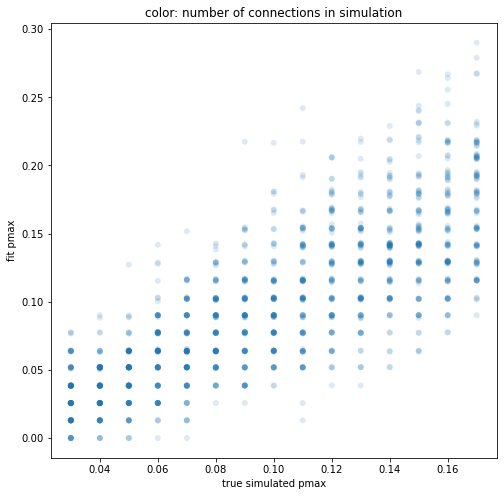

In [19]:
pmax_resolution = 0.01
results = measure_confidence_region(x_probed, fit.pmax, pmax_resolution=pmax_resolution)

fix,ax = plt.subplots(figsize=(8, 8))

ax.scatter(results[:,0], results[:,1], edgecolors='none', alpha=0.15)
    
ax.set_xlabel('true simulated pmax')
ax.set_ylabel('fit pmax')
ax.set_title('color: number of connections in simulation')

The plot above is a tool for characterizing our algorithm for measuring pmax. 

If you focus on a single *column*, you can see the results of 100 simulated experiments with a range of fit_pmax values (for example, at simulated_pmax=0.15, the fit_pmax values span about 0.07-0.20). This tells us "given a true pmax value, how much error can we expect when measuring pmax with a specific set of distances probed".

If instead you focus on a single *row*, you can see what range of simulated_pmax values are likely to result in that specific fit_pmax value (for example, at fit_pmax=0.1, the simulated_pmax values span about 0.07-0.16). This is the range we will use to estimate a confidence interval. In the histogram below, you can see the density of points in a horizontal strip around fit_pmax=0.1:

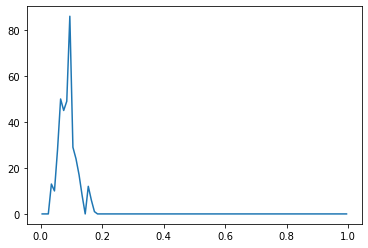

In [20]:
def fit_pmax_slice_histogram(true_pmax, fit_pmax, target_pmax, radius=0.02):
    # take a horizontal slice out where the original fit was and check the distribution of true amps
    top = target_pmax + 0.02
    bottom = target_pmax - 0.02
    mask = (fit_pmax > bottom) & (fit_pmax < top)
    sl = true_pmax[mask]

    bins = np.arange(101) * 0.01
    return np.histogram(sl, bins=bins)

fig,ax = plt.subplots()
hist, bins = fit_pmax_slice_histogram(true_pmax=results[:, 0], fit_pmax=results[:, 1], target_pmax=fit.pmax)
x = 0.5 * (bins[:-1] + bins[1:])
ax.plot(x, hist);

To generate a confidence interval, we will just ask for an interval that contains 95% of the mass in this histogram:

In [21]:
def confidence_interval_from_simulation_results(true_amps, fit_amps, target_pmax, alpha=0.05):
    hist, bins = fit_pmax_slice_histogram(true_amps, fit_amps, target_pmax)
    # greedy approach to finding CI: start adding up largest bins until counting 95% of mass
    order = np.argsort(hist)[::-1]

    cs = np.cumsum(hist[order])
    stop = np.searchsorted(cs, hist.sum() * (1-alpha))
    ci_bins = order[:stop+1]
    lefts = bins[ci_bins]
    rights = bins[ci_bins+1]
    return lefts.min(), rights.max()

print(confidence_interval_from_simulation_results(results[:, 0], results[:, 1], fit.pmax))

(0.03, 0.16)


So given (1) a set of distances probed (x_probed) and (2) a fit result telling us the estimated pmax (fit.pmax), we believe that the _true_ pmax value is somewhere between 0.03 and 0.16. Let's wrap this all up into a single function:

In [22]:
def brute_pmax_confidence_interval(x_probed, connected, alpha=0.05):
    """Return an estimated pmax and confidence intervals given an array of distances probed and a 
    boolean array indicating which probes were connected.
    """
    fit = test_model_class.fit(x_probed, connected, size=fixed_size)
    sim_results = measure_confidence_region(x_probed, fit.pmax)
    ci = confidence_interval_from_simulation_results(sim_results[:, 0], sim_results[:, 1], fit.pmax, alpha=alpha)
    return fit.pmax, ci[0], ci[1]

In [23]:
pmax, lower, upper = brute_pmax_confidence_interval(x_probed, conn)
print("Estimated pmax: %0.2f  95%% CI: (%0.2f-%0.2f)" % (pmax, lower, upper))

Estimated pmax: 0.08  95% CI: (0.03-0.16)


Looks good; let's test it on more data:

In [24]:
n_iter = 100
true_pmax = 0.2
x_probed = np.random.RandomState(8907).choice(all_dist, size=100)
true_model = true_model_class(pmax=true_pmax, size=fixed_size)
results = []
for i in range(n_iter):
    conn = true_model.generate(x_probed, seed=8907+i)
    pmax, lower, upper = brute_pmax_confidence_interval(x_probed, conn)
    results.append((pmax, lower, upper))
    print("%d/%d   pmax: %0.2f  95%% CI: (%0.2f-%0.2f)" % (i+1, n_iter, pmax, lower, upper))
    
results = np.array(results)
fails = ((results[:,1] > true_pmax) | (results[:,2] < true_pmax)).sum()
print("Tests with true pmax outside CI: %d / %d" % (fails, n_iter))


1/100   pmax: 0.17  95% CI: (0.09-0.27)
2/100   pmax: 0.15  95% CI: (0.08-0.27)
3/100   pmax: 0.21  95% CI: (0.12-0.35)
4/100   pmax: 0.15  95% CI: (0.08-0.27)
5/100   pmax: 0.21  95% CI: (0.12-0.35)
6/100   pmax: 0.24  95% CI: (0.15-0.37)
7/100   pmax: 0.11  95% CI: (0.06-0.20)
8/100   pmax: 0.27  95% CI: (0.17-0.38)
9/100   pmax: 0.28  95% CI: (0.18-0.40)
10/100   pmax: 0.28  95% CI: (0.18-0.39)
11/100   pmax: 0.24  95% CI: (0.15-0.37)
12/100   pmax: 0.19  95% CI: (0.10-0.31)
13/100   pmax: 0.13  95% CI: (0.07-0.23)
14/100   pmax: 0.17  95% CI: (0.09-0.27)
15/100   pmax: 0.20  95% CI: (0.10-0.30)
16/100   pmax: 0.07  95% CI: (0.03-0.14)
17/100   pmax: 0.15  95% CI: (0.08-0.27)
18/100   pmax: 0.18  95% CI: (0.08-0.28)
19/100   pmax: 0.20  95% CI: (0.10-0.30)
20/100   pmax: 0.21  95% CI: (0.12-0.35)
21/100   pmax: 0.23  95% CI: (0.13-0.36)
22/100   pmax: 0.24  95% CI: (0.15-0.37)
23/100   pmax: 0.20  95% CI: (0.10-0.30)
24/100   pmax: 0.21  95% CI: (0.12-0.35)
25/100   pmax: 0.17  95% 

So this method works reasonably well, but is very inefficient to compute and subject to some random noise. Additionally, it suffers for very low pmax values since we would need to simulate many more experiments to confidently cover those regions. Perhaps we can find a way to simplify the process? 

## Question 2.1: how far can we optimize gaussian MLE with fixed sigma?

Going back to a scatter plot we showed earlier, one interesting feature is that the fit_pmax seems to depend almost entirely on the number of connections found in an experiment, and very little on _which_ of the tests turned out to be connected:

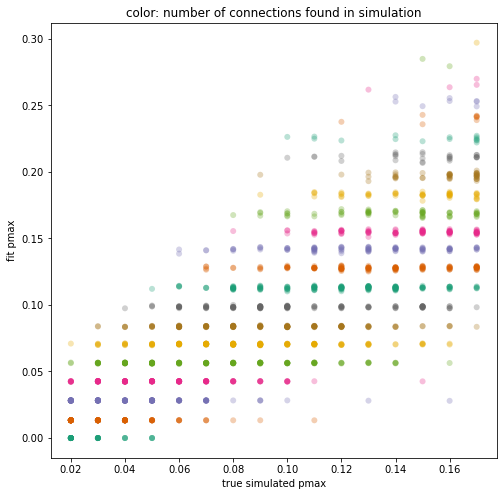

In [25]:
results = measure_confidence_region(x_probed, fit.pmax, pmax_resolution=0.01)

fig,ax = plt.subplots(figsize=(8, 8))

cmap = plt.cm.Dark2
c = cmap((results[:,2] % 8) / 7)

ax.scatter(results[:,0], results[:,1], c=c, edgecolors='none', alpha=0.3)
    
ax.set_xlabel('true simulated pmax')
ax.set_ylabel('fit pmax')
ax.set_title('color: number of connections found in simulation');

This suggests that we can approximate the maximum likelihood estimation by assuming that it depends only on the number of connections found, rather than on the complete likelihood function.

Another way we can see this if by looking at the derivative of the likelihood function:

In [26]:
from sympy import Sum, Eq, exp, log, IndexedBase, symbols, diff
import sympy

# p = sympy.Function('p')
def p(x, a, σ):
    return a * exp(-x**2 / (2 * σ**2))

x_con = IndexedBase('x_con')
x_unc = IndexedBase('x_unc')
i, p_max, σ, n_con, n_unc = symbols('i p_max σ n_con n_unc')
likelihood = (
    Sum(log(p(x_con[i], p_max, σ)), (i, 1, n_con)) + 
    Sum(log(1 - p(x_unc[i], p_max, σ)), (i, 1, n_unc))
)

In [27]:
likelihood

Sum(log(p_max*exp(-x_con[i]**2/(2*σ**2))), (i, 1, n_con)) + Sum(log(-p_max*exp(-x_unc[i]**2/(2*σ**2)) + 1), (i, 1, n_unc))

Above is the expression for the gaussian model likelihood used in our maximum likelihood estimation. At maximum likelihood (or minimum fit error), the derivative of this expression is 0.

In [28]:
Eq(diff(likelihood, p_max), 0)

Eq(Sum(1/p_max, (i, 1, n_con)) + Sum(-exp(-x_unc[i]**2/(2*σ**2))/(-p_max*exp(-x_unc[i]**2/(2*σ**2)) + 1), (i, 1, n_unc)), 0)

Can we just directly solve this equation?

In [29]:
sympy.solveset(Eq(diff(likelihood, p_max), 0), p_max, sympy.Reals)

ConditionSet(p_max, Eq(Sum(1/p_max, (i, 1, n_con)) + Sum(-exp(-x_unc[i]**2/(2*σ**2))/(-p_max*exp(-x_unc[i]**2/(2*σ**2)) + 1), (i, 1, n_unc)), 0), Reals)

Maybe not, but let's have a closer look..

In [30]:
sympy.simplify(Eq(diff(likelihood, p_max), 0))

Eq(n_con/p_max + Sum(1/(p_max - exp(x_unc[i]**2/(2*σ**2))), (i, 1, n_unc)), 0)

The first term in this equation deals with the likelihood of all _connected_ pairs, and the second term deals with all _unconnected_ pairs. Since these terms sum to 0, they must be equal and opposite:

In [31]:
Eq(n_con / p_max, Sum(1 / (p_max - exp(x_unc[i]**2 / 2*σ**2)), (i, 1, n_unc)))

Eq(n_con/p_max, Sum(1/(p_max - exp(σ**2*x_unc[i]**2/2)), (i, 1, n_unc)))

So let's say we test 100 pairs in an experiment and find only 3 connected (eg. pairs 5, 43, and 66). The equation above tells us the optimal value of pmax. Now if we keep all the distances probed constant and instead randomly pick 3 different pairs to be connected (eg. 27, 76, 81), how will this affect pmax? The left side of the equation has no dependence on the distances of connected pairs. The right side of the equation has 97 terms, only 3 of which have changed, so we expect it to be _mostly_ unaffected. The result again is that pmax depends mostly on the number of connected pairs and the distances at which connections are *probed*, but not the distances at which connections are *found*.

Let's test this idea by plotting pmax vs the number of connections in each simulated experiment:

Text(0, 0.5, 'number of connections')

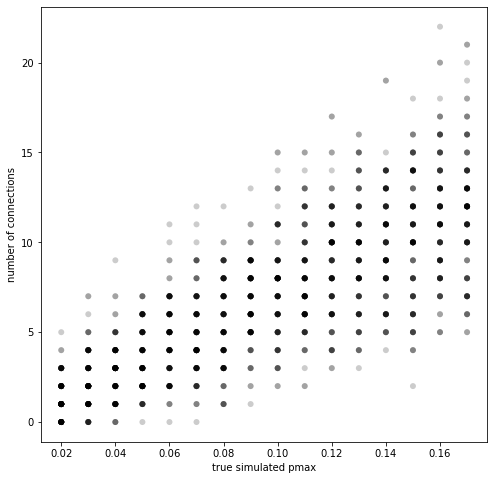

In [32]:
pmax_vals = np.unique(results[:,0])
pmax_vals.sort()
results2 = []
for pmax in pmax_vals:
    model = test_model_class(pmax=pmax, size=fixed_size)
    for i in range(100):
        ncon = model.generate(x_probed).sum()
        results2.append((pmax, ncon))
results2 = np.array(results2)
fig,ax = plt.subplots(figsize=(8, 8))

ax.scatter(results2[:,0], results2[:,1], c='k', edgecolors='none', alpha=0.2)
    
ax.set_xlabel('true simulated pmax')
ax.set_ylabel('number of connections')


This result is strikingly similar to the one we generated previously using MLE. Each column here is like a binomial distribution but where each coin-flip has a different probability determined by the connectivity profile. We can make one more approximation here by assuming this distribution is very similar to a standard binomial distribution using the _mean_ probability from the connectivity profile:

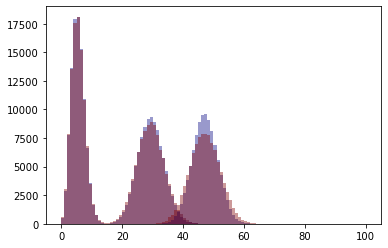

In [33]:
for pmax in (0.1, 0.5, 1.0):
    p = np.random.random(size=100) * pmax
    n1 = []
    n2 = []
    for i in range(100000):
        n1.append((np.random.random(size=len(p)) < p).sum())
        n2.append((np.random.random(size=len(p)) < p.mean()).sum())
    bins = np.arange(len(p)+1)
    plt.hist(n1, bins=bins, color=(0, 0, .5, .4));
    plt.hist(n2, bins=bins, color=(.5, 0, 0, .4));


It looks like this works, and we would slightly overestimate the width of some confidence intervals by making this approximation.

Applying this idea more fully:

In [34]:
from scipy.stats import binom

def approx_pmax_confidence_interval(x_probed, connected, alpha=0.05):
    """Return an estimated pmax and confidence intervals given an array of distances probed and a 
    boolean array indicating which probes were connected.
    """
    pmax_vals = np.linspace(0, 1, 1000)
    binom_vals = []
    n_conn = connected.sum()
    max_prob = test_model_class(pmax=1.0, size=fixed_size).connection_probability(x_probed).mean()
    for pmax in pmax_vals:
        prob = max_prob * pmax
        binom_vals.append(binom.pmf(k=n_conn, n=len(x_probed), p=prob))

    binom_vals = np.array(binom_vals)
    order = np.argsort(binom_vals)[::-1]
    sorted_binom_vals = binom_vals[order]
    mask = (np.cumsum(sorted_binom_vals) / sorted_binom_vals.sum()) <= (1.0 - alpha)
    sorted_pmax_vals = pmax_vals[order]
    masked_pmax_vals = sorted_pmax_vals[mask]
    lower = masked_pmax_vals.min()
    upper = masked_pmax_vals.max()

    # most likely point in distribution
    est_pmax = pmax_vals[np.argmax(binom_vals)]
        
    return est_pmax, lower, upper
    

rng = np.random.RandomState(5568)
x_probed = rng.choice(all_dist, size=100)
true_model = true_model_class(pmax=0.2, size=fixed_size)
connected = true_model.generate(x_probed, seed=5568)

pmax, lower, upper = approx_pmax_confidence_interval(x_probed, connected)

print(pmax, lower, upper)

0.1941941941941942 0.11411411411411411 0.29929929929929927


The method above can be simplified further by using a standard binomial confidence interval rather than deriving it manually:

In [35]:
def approx_pmax_confidence_interval(x_probed, connected, alpha=0.05):
    """Return an estimated pmax and confidence intervals given an array of distances probed and a 
    boolean array indicating which probes were connected.
    """
    n_conn = connected.sum()
    n_test = len(x_probed)
    max_prob = test_model_class(pmax=1.0, size=fixed_size).connection_probability(x_probed).mean()

    # estimated pmax is just the proportion of connections multiplied by a scale factor
    est_pmax = (n_conn / n_test) / max_prob
    
    # and for the CI, we can just use a standard binomial confidence interval scaled by the same factor
    from aisynphys.connectivity import connection_probability_ci
    lower, upper = connection_probability_ci(n_conn, n_test, alpha)
    
    return est_pmax, lower / max_prob, upper / max_prob

pmax, lower, upper = approx_pmax_confidence_interval(x_probed, connected)

print(pmax, lower, upper)

0.1943513176402566 0.10926070823546956 0.3105844855168901


Compare the approximate method to the brute-force method:

In [36]:
true_pmax = np.linspace(0, 1, 100)
results = []
for i in range(len(true_pmax)):
    x_probed = np.random.RandomState(18908+i).choice(all_dist, size=100)
    true_model = true_model_class(pmax=true_pmax[i], size=fixed_size)
    conn = true_model.generate(x_probed, seed=8908+i)
    pmax1, lower1, upper1 = approx_pmax_confidence_interval(x_probed, conn)
    pmax2, lower2, upper2 = brute_pmax_confidence_interval(x_probed, conn)
    results.append(((pmax1, lower1, upper1), (pmax2, lower2, upper2)))
    print("%d/%d   pmax: %0.2f  95%% CI: (%0.2f-%0.2f)" % (i+1, n_iter, pmax1, lower1, upper1))
    
results = np.array(results)

1/100   pmax: 0.00  95% CI: (0.00-0.05)
2/100   pmax: 0.00  95% CI: (0.00-0.05)
3/100   pmax: 0.01  95% CI: (0.00-0.07)
4/100   pmax: 0.00  95% CI: (0.00-0.05)
5/100   pmax: 0.01  95% CI: (0.00-0.07)
6/100   pmax: 0.03  95% CI: (0.00-0.10)
7/100   pmax: 0.01  95% CI: (0.00-0.08)
8/100   pmax: 0.08  95% CI: (0.03-0.17)
9/100   pmax: 0.13  95% CI: (0.06-0.24)
10/100   pmax: 0.14  95% CI: (0.07-0.25)
11/100   pmax: 0.09  95% CI: (0.04-0.19)
12/100   pmax: 0.12  95% CI: (0.06-0.22)
13/100   pmax: 0.14  95% CI: (0.07-0.24)
14/100   pmax: 0.07  95% CI: (0.02-0.16)
15/100   pmax: 0.05  95% CI: (0.01-0.13)
16/100   pmax: 0.11  95% CI: (0.05-0.20)
17/100   pmax: 0.14  95% CI: (0.07-0.24)
18/100   pmax: 0.20  95% CI: (0.12-0.32)
19/100   pmax: 0.21  95% CI: (0.12-0.32)
20/100   pmax: 0.19  95% CI: (0.11-0.31)
21/100   pmax: 0.20  95% CI: (0.12-0.32)
22/100   pmax: 0.28  95% CI: (0.18-0.41)
23/100   pmax: 0.22  95% CI: (0.13-0.35)
24/100   pmax: 0.20  95% CI: (0.11-0.32)
25/100   pmax: 0.22  95% 

In [37]:
fails = ((results[:, 0, 1] > true_pmax) | (results[:, 0, 2] < true_pmax)).sum()
print("Approx. CI tests with true pmax outside CI: %d / %d" % (fails, len(results)))

fails = ((results[:, 1, 1] > true_pmax) | (results[:, 1, 2] < true_pmax)).sum()
print("Brute. CI tests with true pmax outside CI: %d / %d" % (fails, len(results)))

Approx. CI tests with true pmax outside CI: 3 / 100
Brute. CI tests with true pmax outside CI: 8 / 100


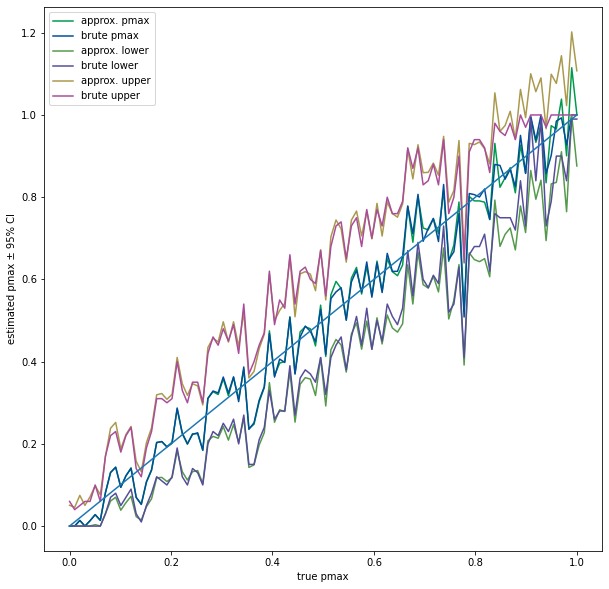

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

for i in range(3):
    label = ['pmax', 'lower', 'upper']
    ax.plot(true_pmax, results[:, 0, i], color=(i/3, 0.6, 0.3), label='approx. '+label[i])
    ax.plot(true_pmax, results[:, 1, i], color=(i/3, 0.3, 0.6), label='brute '+label[i])

ax.set_xlabel('true pmax')
ax.set_ylabel('estimated pmax ± 95% CI')
ax.plot([0, 1], [0, 1])
ax.legend()

From the results above, it looks like the approximate method for estimating pmax and confidence intervals works well (gives very similar results to the brute-force method) and runs much more quickly.

## Summary of results:

1. **What is the best way to model a connection probability profile?**

We have chosen to use a gaussian connectivity profile, although other profile shapes seemed to fit our data equally well.

2. **What is the best way to fit a connection probability distribution?**

Our cleanest results came from a maximum likelihood estimation with the gaussian σ fixed at 150 µm. However, this approach can be approximated much more efficiently as the proportion of connections multiplied by a scale factor.

3. **What is the best way to determine confidence intervals on that fit?**

Using the same approximation, we can use a standard binomial confidence interval multiplied by the same scale factor.


These results have been baked into a single function `aisynphys.connectivity.gaussian_pmax_ci()`.